In [ ]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels.panel import RandomEffects
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Set plotting style
# plt.style.use('seaborn-whitegrid') # This line caused the error
sns.set_theme(style="whitegrid") # Use sns.set_theme to apply Seaborn styles
sns.set_context("paper", font_scale=1.5) # Set the context after applying theme

In [ ]:
# Load datasets (assuming files are uploaded to Colab)
from google.colab import files
uploaded = files.upload()  # Upload weather, ridership, and socioeconomic data

# Read the data files
weather_data = pd.read_csv('3986077.csv')
ridership_data = pd.read_csv('Jan19_to_Present.csv')
socioeconomic_data = pd.read_csv('social_economic_data_rideship.csv')

# Display basic information about the datasets
print("Weather data dimensions:", weather_data.shape)
print("Ridership data dimensions:", ridership_data.shape)
print("Socioeconomic data dimensions:", socioeconomic_data.shape)

# Convert weather DATE to datetime and set as index
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
weather_data_indexed = weather_data.set_index('DATE')

# Display the first few rows of each dataset
print("\nWeather Data Sample:")
print(weather_data.head())
print("\nRidership Data Sample:")
print(ridership_data.head())
print("\nSocioeconomic Data Sample:")
print(socioeconomic_data.head())

Saving 3986077.csv to 3986077.csv
Saving Jan19_to_Present.csv to Jan19_to_Present.csv
Saving social_economic_data_rideship.csv to social_economic_data_rideship.csv
Weather data dimensions: (2223, 15)
Ridership data dimensions: (28013, 7)
Socioeconomic data dimensions: (7, 73)

Weather Data Sample:
       STATION                                       NAME       DATE  PRCP  SNWD  TMAX  TMIN  WT01  WT02  WT03  WT04  WT05  WT06  WT08  WT09
0  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US 2019-01-01  0.09   0.0    61    43   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US 2019-01-02  0.00   0.0    43    37   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US 2019-01-03  0.00   0.0    46    34   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
3  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US 2019-01-04  0.04   0.0    45    31   1.0   NaN   NaN   NaN   NaN   NaN   NaN   

In [ ]:
# Check for missing values in weather data
print("\nMissing values in weather data:")
print(weather_data.isnull().sum())

# Check for missing values in ridership data
print("\nMissing values in ridership data:")
print(ridership_data.isnull().sum())

# Clean weather data
def clean_weather_data(df):
    """
    Clean weather data by handling missing values and converting data types.

    Parameters:
    -----------
    df : pandas.DataFrame
        Raw weather data with DATE, PRCP, SNWD, TMAX, TMIN columns

    Returns:
    --------
    pandas.DataFrame
        Cleaned weather data
    """
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Convert DATE to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df_clean['DATE']):
        df_clean['DATE'] = pd.to_datetime(df_clean['DATE'])

    # Convert numeric columns to float
    numeric_cols = ['PRCP', 'SNWD', 'TMAX', 'TMIN']
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Fill missing values with appropriate methods
    # For precipitation, fill with 0 (assuming missing means no precipitation)
    df_clean['PRCP'] = df_clean['PRCP'].fillna(0)

    # For temperature, use forward fill then backward fill (assumes temporal continuity)
    df_clean['TMAX'] = df_clean['TMAX'].fillna(method='ffill').fillna(method='bfill')
    df_clean['TMIN'] = df_clean['TMIN'].fillna(method='ffill').fillna(method='bfill')

    # For snow depth, fill with 0 for non-winter months, and forward/backward fill for winter
    winter_mask = (df_clean['DATE'].dt.month.isin([12, 1, 2, 3]))
    df_clean.loc[~winter_mask, 'SNWD'] = df_clean.loc[~winter_mask, 'SNWD'].fillna(0)
    df_clean.loc[winter_mask, 'SNWD'] = df_clean.loc[winter_mask, 'SNWD'].fillna(method='ffill').fillna(method='bfill').fillna(0)

    # Extract year and month for aggregation
    df_clean['YEAR'] = df_clean['DATE'].dt.year
    df_clean['MONTH'] = df_clean['DATE'].dt.month
    df_clean['MONTH_NAME'] = df_clean['DATE'].dt.strftime('%B')
    df_clean['DAY'] = df_clean['DATE'].dt.day
    df_clean['DOW'] = df_clean['DATE'].dt.dayofweek  # 0=Monday, 6=Sunday
    df_clean['WEEKEND'] = df_clean['DOW'].isin([5, 6]).astype(int)

    # Create season variable
    seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
               6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall',
               11: 'Fall', 12: 'Winter'}
    df_clean['SEASON'] = df_clean['MONTH'].map(seasons)

    return df_clean

# Clean ridership data
def clean_ridership_data(df):
    """
    Clean ridership data by standardizing formats and adding time variables.

    Parameters:
    -----------
    df : pandas.DataFrame
        Raw ridership data with Mode, Service Type, Year, Month, Route, Ridership columns

    Returns:
    --------
    pandas.DataFrame
        Cleaned ridership data
    """
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Ensure Year and Month are strings for consistent handling
    df_clean['Year'] = df_clean['Year'].astype(str)
    df_clean['Month'] = df_clean['Month'].astype(str)

    # Create numeric month column
    month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
    df_clean['MONTH_NUM'] = df_clean['Month'].map(month_map)

    # Create date column for the first day of each month (for time series analysis)
    df_clean['DATE'] = pd.to_datetime(df_clean['Year'] + '-' + df_clean['MONTH_NUM'].astype(str) + '-01')

    # Create year-month identifier for joining
    df_clean['YEARMONTH'] = df_clean['Year'] + '-' + df_clean['MONTH_NUM'].astype(str).str.zfill(2)

    # Create transit mode categories
    mode_categories = {
        'Bus': 'Bus',
        'Trackless Trolley': 'Rail',
        'Trolley': 'Rail'
    }
    df_clean['MODE_CAT'] = df_clean['Mode'].map(mode_categories)

    # Convert Route to string
    df_clean['Route'] = df_clean['Route'].astype(str)

    # Create unique route-mode identifier
    df_clean['ROUTE_ID'] = df_clean['Mode'] + '_' + df_clean['Route']

    return df_clean

# Apply cleaning functions
weather_clean = clean_weather_data(weather_data)
ridership_clean = clean_ridership_data(ridership_data)

# Verify cleaning results
print("\nCleaned Weather Data Sample:")
print(weather_clean.head())
print("\nCleaned Ridership Data Sample:")
print(ridership_clean.head())

# Check if all missing values have been handled
print("\nRemaining missing values in weather data:")
print(weather_clean[['PRCP', 'SNWD', 'TMAX', 'TMIN']].isnull().sum())
print("\nRemaining missing values in ridership data:")
print(ridership_clean[['Ridership', 'YEARMONTH', 'DATE']].isnull().sum())


Missing values in weather data:
STATION       0
NAME          0
DATE          0
PRCP          0
SNWD          2
TMAX          0
TMIN          0
WT01       1470
WT02       2167
WT03       2005
WT04       2202
WT05       2221
WT06       2206
WT08       2062
WT09       2220
dtype: int64

Missing values in ridership data:
Mode            0
Service Type    0
Source          0
Year            0
Month           0
Route           0
Ridership       7
dtype: int64

Cleaned Weather Data Sample:
       STATION                                       NAME       DATE  PRCP  SNWD  TMAX  TMIN  WT01  WT02  WT03  WT04  WT05  WT06  WT08  WT09  YEAR  MONTH MONTH_NAME  DAY  DOW  WEEKEND  SEASON
0  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US 2019-01-01  0.09   0.0    61    43   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  2019      1    January    1    1        0  Winter
1  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US 2019-01-02  0.00   0.0    43    37   NaN   NaN   NaN   NaN   NaN   N

***2.2 Data Cleaning and Quality Assessment***

In [ ]:
# Check for missing values in weather data
print("\nMissing values in weather data:")
print(weather_data.isnull().sum())

# Check for missing values in ridership data
print("\nMissing values in ridership data:")
print(ridership_data.isnull().sum())

# Clean weather data
def clean_weather_data(df):
    """
    Clean weather data by handling missing values and converting data types.

    Parameters:
    -----------
    df : pandas.DataFrame
        Raw weather data with DATE, PRCP, SNWD, TMAX, TMIN columns

    Returns:
    --------
    pandas.DataFrame
        Cleaned weather data
    """
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Convert DATE to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df_clean['DATE']):
        df_clean['DATE'] = pd.to_datetime(df_clean['DATE'])

    # Convert numeric columns to float
    numeric_cols = ['PRCP', 'SNWD', 'TMAX', 'TMIN']
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Fill missing values with appropriate methods
    # For precipitation, fill with 0 (assuming missing means no precipitation)
    df_clean['PRCP'] = df_clean['PRCP'].fillna(0)

    # For temperature, use forward fill then backward fill (assumes temporal continuity)
    df_clean['TMAX'] = df_clean['TMAX'].fillna(method='ffill').fillna(method='bfill')
    df_clean['TMIN'] = df_clean['TMIN'].fillna(method='ffill').fillna(method='bfill')

    # For snow depth, fill with 0 for non-winter months, and forward/backward fill for winter
    winter_mask = (df_clean['DATE'].dt.month.isin([12, 1, 2, 3]))
    df_clean.loc[~winter_mask, 'SNWD'] = df_clean.loc[~winter_mask, 'SNWD'].fillna(0)
    df_clean.loc[winter_mask, 'SNWD'] = df_clean.loc[winter_mask, 'SNWD'].fillna(method='ffill').fillna(method='bfill').fillna(0)

    # Extract year and month for aggregation
    df_clean['YEAR'] = df_clean['DATE'].dt.year
    df_clean['MONTH'] = df_clean['DATE'].dt.month
    df_clean['MONTH_NAME'] = df_clean['DATE'].dt.strftime('%B')
    df_clean['DAY'] = df_clean['DATE'].dt.day
    df_clean['DOW'] = df_clean['DATE'].dt.dayofweek  # 0=Monday, 6=Sunday
    df_clean['WEEKEND'] = df_clean['DOW'].isin([5, 6]).astype(int)

    # Create season variable
    seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
               6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall',
               11: 'Fall', 12: 'Winter'}
    df_clean['SEASON'] = df_clean['MONTH'].map(seasons)

    return df_clean

# Clean ridership data
def clean_ridership_data(df):
    """
    Clean ridership data by standardizing formats and adding time variables.

    Parameters:
    -----------
    df : pandas.DataFrame
        Raw ridership data with Mode, Service Type, Year, Month, Route, Ridership columns

    Returns:
    --------
    pandas.DataFrame
        Cleaned ridership data
    """
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Ensure Year and Month are strings for consistent handling
    df_clean['Year'] = df_clean['Year'].astype(str)
    df_clean['Month'] = df_clean['Month'].astype(str)

    # Create numeric month column
    month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
    df_clean['MONTH_NUM'] = df_clean['Month'].map(month_map)

    # Create date column for the first day of each month (for time series analysis)
    df_clean['DATE'] = pd.to_datetime(df_clean['Year'] + '-' + df_clean['MONTH_NUM'].astype(str) + '-01')

    # Create year-month identifier for joining
    df_clean['YEARMONTH'] = df_clean['Year'] + '-' + df_clean['MONTH_NUM'].astype(str).str.zfill(2)

    # Create transit mode categories
    mode_categories = {
        'Bus': 'Bus',
        'Trackless Trolley': 'Rail',
        'Trolley': 'Rail'
    }
    df_clean['MODE_CAT'] = df_clean['Mode'].map(mode_categories)

    # Convert Route to string
    df_clean['Route'] = df_clean['Route'].astype(str)

    # Create unique route-mode identifier
    df_clean['ROUTE_ID'] = df_clean['Mode'] + '_' + df_clean['Route']

    return df_clean

# Apply cleaning functions
weather_clean = clean_weather_data(weather_data)
ridership_clean = clean_ridership_data(ridership_data)

# Verify cleaning results
print("\nCleaned Weather Data Sample:")
print(weather_clean.head())
print("\nCleaned Ridership Data Sample:")
print(ridership_clean.head())

# Check if all missing values have been handled
print("\nRemaining missing values in weather data:")
print(weather_clean[['PRCP', 'SNWD', 'TMAX', 'TMIN']].isnull().sum())
print("\nRemaining missing values in ridership data:")
print(ridership_clean[['Ridership', 'YEARMONTH', 'DATE']].isnull().sum())

# ... your plotting code ...

plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.suptitle('Extreme Weather Events in Philadelphia (2019-2025)', y=1.02, fontsize=16)
plt.show()



Missing values in weather data:
STATION       0
NAME          0
DATE          0
PRCP          0
SNWD          2
TMAX          0
TMIN          0
WT01       1470
WT02       2167
WT03       2005
WT04       2202
WT05       2221
WT06       2206
WT08       2062
WT09       2220
dtype: int64

Missing values in ridership data:
Mode            0
Service Type    0
Source          0
Year            0
Month           0
Route           0
Ridership       7
dtype: int64

Cleaned Weather Data Sample:
       STATION                                       NAME       DATE  PRCP  SNWD  TMAX  TMIN  WT01  WT02  WT03  WT04  WT05  WT06  WT08  WT09  YEAR  MONTH MONTH_NAME  DAY  DOW  WEEKEND  SEASON
0  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US 2019-01-01  0.09   0.0    61    43   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  2019      1    January    1    1        0  Winter
1  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US 2019-01-02  0.00   0.0    43    37   NaN   NaN   NaN   NaN   NaN   N

<Figure size 640x480 with 0 Axes>


Extreme Weather Thresholds:
Winter: Hot > 62.0°F, Cold < 17.0°F
Spring: Hot > 84.0°F, Cold < 30.0°F
Summer: Hot > 95.0°F, Cold < 59.0°F
Fall: Hot > 87.0°F, Cold < 33.0°F
Heavy Precipitation: > 1.37 inches

Extreme Weather Event Counts:
Very Hot Days: 139
Very Cold Days: 131
Heavy Precipitation Days: 39
Consecutive Hot Days: 56
Consecutive Cold Days: 66
Consecutive Precipitation Days: 2
Heat Wave Days (3+ consecutive): 23
Cold Wave Days (3+ consecutive): 30


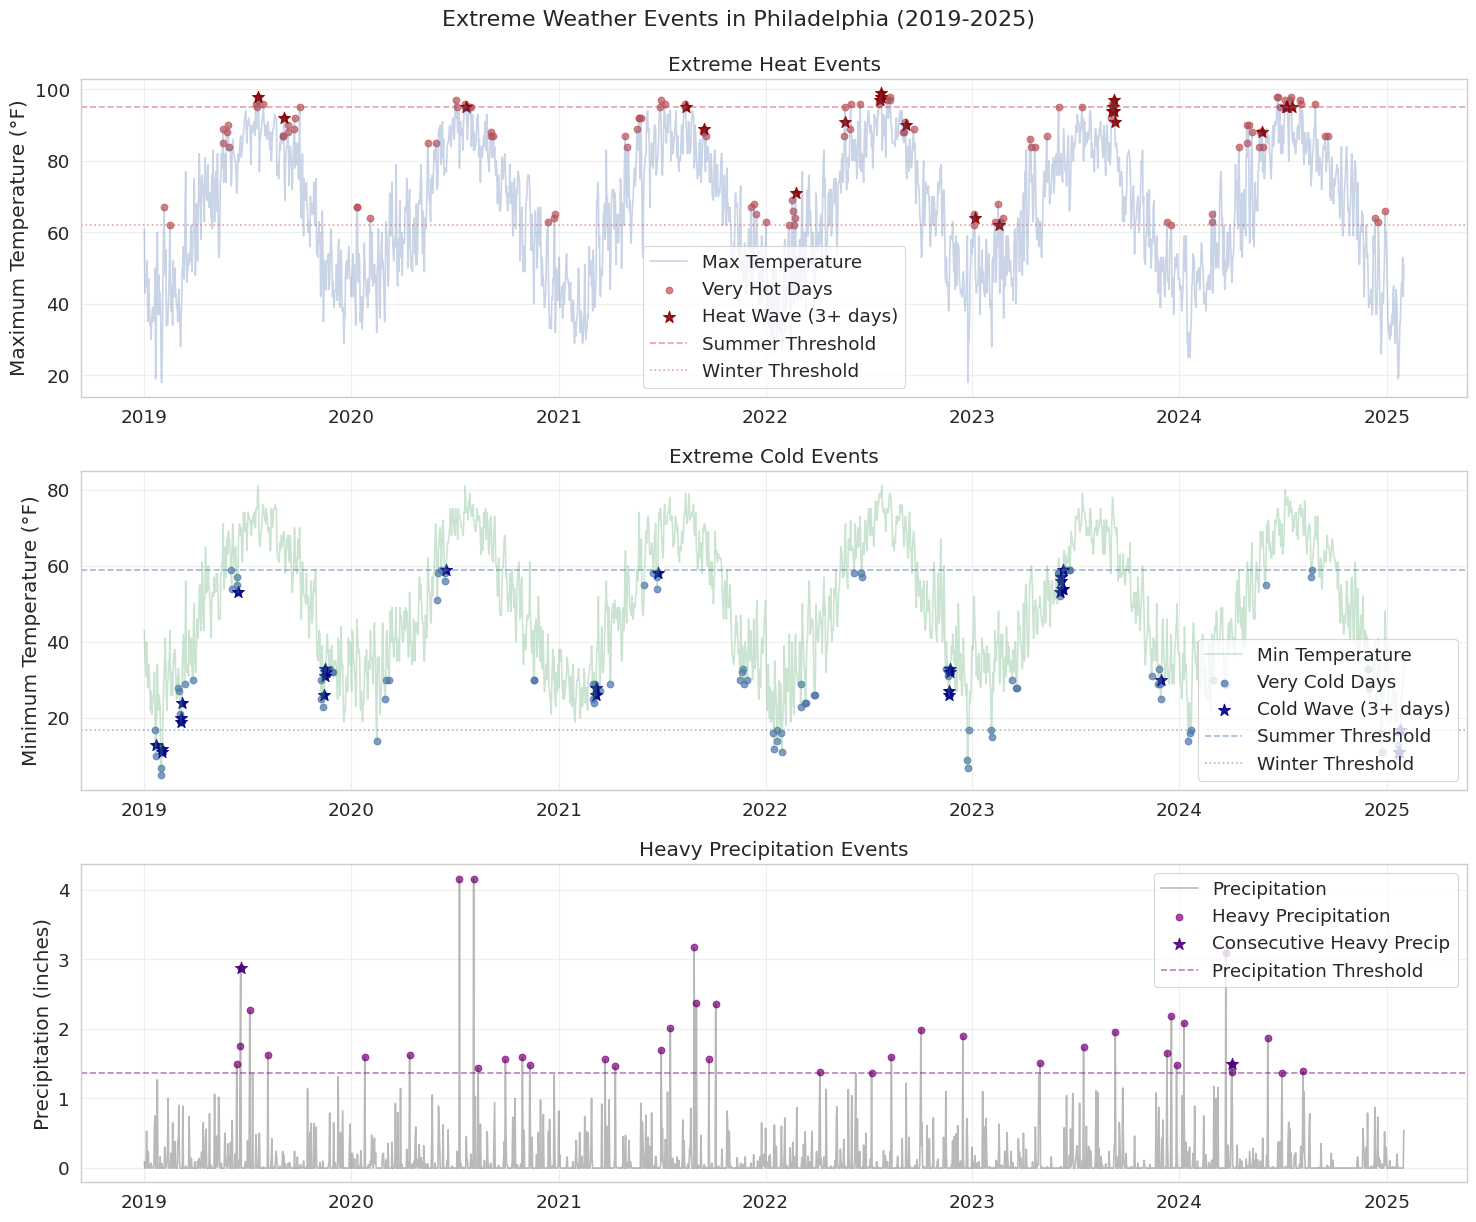

<Figure size 640x480 with 0 Axes>

In [ ]:
def define_extreme_weather_events(df, hot_percentile=95, cold_percentile=5, precip_percentile=95):
    """
    Define extreme weather events based on percentile thresholds of the distribution.

    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned weather data
    hot_percentile : float
        Percentile threshold for defining extremely hot days (default: 95)
    cold_percentile : float
        Percentile threshold for defining extremely cold days (default: 5)
    precip_percentile : float
        Percentile threshold for defining heavy precipitation days (default: 95)

    Returns:
    --------
    pandas.DataFrame
        Weather data with added extreme event indicators
    """
    # Create a copy to avoid modifying the original
    df_extremes = df.copy()

    # Calculate seasonal thresholds for temperature to account for seasonal expectations
    seasons = df_extremes['SEASON'].unique()

    # Create empty columns for extreme weather indicators
    df_extremes['VERY_HOT'] = 0
    df_extremes['VERY_COLD'] = 0
    df_extremes['HEAVY_PRECIP'] = 0

    # Apply seasonal thresholds for temperature extremes
    for season in seasons:
        season_data = df_extremes[df_extremes['SEASON'] == season]

        # Extreme heat threshold (seasonal)
        tmax_threshold = np.percentile(season_data['TMAX'], hot_percentile)
        df_extremes.loc[df_extremes['SEASON'] == season, 'VERY_HOT'] = (
            df_extremes.loc[df_extremes['SEASON'] == season, 'TMAX'] >= tmax_threshold).astype(int)

        # Extreme cold threshold (seasonal)
        tmin_threshold = np.percentile(season_data['TMIN'], cold_percentile)
        df_extremes.loc[df_extremes['SEASON'] == season, 'VERY_COLD'] = (
            df_extremes.loc[df_extremes['SEASON'] == season, 'TMIN'] <= tmin_threshold).astype(int)

    # Heavy precipitation threshold (not seasonal)
    # Using only days with non-zero precipitation to calculate threshold
    prcp_threshold = np.percentile(df_extremes.loc[df_extremes['PRCP'] > 0, 'PRCP'], precip_percentile)
    df_extremes['HEAVY_PRECIP'] = (df_extremes['PRCP'] >= prcp_threshold).astype(int)

    # Document the thresholds used
    thresholds = {}
    for season in seasons:
        season_data = df_extremes[df_extremes['SEASON'] == season]
        thresholds[season] = {
            'hot_threshold': np.percentile(season_data['TMAX'], hot_percentile),
            'cold_threshold': np.percentile(season_data['TMIN'], cold_percentile)
        }
    thresholds['precipitation'] = prcp_threshold

    print("\nExtreme Weather Thresholds:")
    for season, values in thresholds.items():
        if season != 'precipitation':
            print(f"{season}: Hot > {values['hot_threshold']:.1f}°F, Cold < {values['cold_threshold']:.1f}°F")
        else:
            print(f"Heavy Precipitation: > {values:.2f} inches")

    # Identify consecutive extreme days
    df_extremes['CONSEC_HOT'] = ((df_extremes['VERY_HOT'] == 1) &
                                (df_extremes['VERY_HOT'].shift(1) == 1)).astype(int)
    df_extremes['CONSEC_COLD'] = ((df_extremes['VERY_COLD'] == 1) &
                                 (df_extremes['VERY_COLD'].shift(1) == 1)).astype(int)
    df_extremes['CONSEC_PRECIP'] = ((df_extremes['HEAVY_PRECIP'] == 1) &
                                   (df_extremes['HEAVY_PRECIP'].shift(1) == 1)).astype(int)

    # Create single (isolated) extreme day indicators
    df_extremes['SINGLE_HOT'] = ((df_extremes['VERY_HOT'] == 1) &
                                (df_extremes['CONSEC_HOT'] == 0)).astype(int)
    df_extremes['SINGLE_COLD'] = ((df_extremes['VERY_COLD'] == 1) &
                                 (df_extremes['CONSEC_COLD'] == 0)).astype(int)
    df_extremes['SINGLE_PRECIP'] = ((df_extremes['HEAVY_PRECIP'] == 1) &
                                   (df_extremes['CONSEC_PRECIP'] == 0)).astype(int)

    # Create heat wave and cold wave indicators (3+ consecutive days)
    df_extremes['HEATWAVE'] = 0
    df_extremes['COLDWAVE'] = 0

    # Find sequences of 3 or more consecutive hot/cold days
    hot_count = 0
    cold_count = 0

    for i in range(len(df_extremes)):
        if df_extremes.iloc[i]['VERY_HOT'] == 1:
            hot_count += 1
        else:
            hot_count = 0

        if df_extremes.iloc[i]['VERY_COLD'] == 1:
            cold_count += 1
        else:
            cold_count = 0

        if hot_count >= 3:
            df_extremes.iloc[i, df_extremes.columns.get_loc('HEATWAVE')] = 1

        if cold_count >= 3:
            df_extremes.iloc[i, df_extremes.columns.get_loc('COLDWAVE')] = 1

    # Count extreme days by month for aggregation
    print("\nExtreme Weather Event Counts:")
    print(f"Very Hot Days: {df_extremes['VERY_HOT'].sum()}")
    print(f"Very Cold Days: {df_extremes['VERY_COLD'].sum()}")
    print(f"Heavy Precipitation Days: {df_extremes['HEAVY_PRECIP'].sum()}")
    print(f"Consecutive Hot Days: {df_extremes['CONSEC_HOT'].sum()}")
    print(f"Consecutive Cold Days: {df_extremes['CONSEC_COLD'].sum()}")
    print(f"Consecutive Precipitation Days: {df_extremes['CONSEC_PRECIP'].sum()}")
    print(f"Heat Wave Days (3+ consecutive): {df_extremes['HEATWAVE'].sum()}")
    print(f"Cold Wave Days (3+ consecutive): {df_extremes['COLDWAVE'].sum()}")

    return df_extremes, thresholds

# Apply extreme weather definition
weather_with_extremes, weather_thresholds = define_extreme_weather_events(weather_clean)

# Visualize extreme weather events
plt.figure(figsize=(15, 12))

# Plot temperature extremes
ax1 = plt.subplot(3, 1, 1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['TMAX'], 'b-', alpha=0.3, label='Max Temperature')
plt.scatter(weather_with_extremes.loc[weather_with_extremes['VERY_HOT']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['VERY_HOT']==1, 'TMAX'],
            color='r', marker='o', label='Very Hot Days', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['HEATWAVE']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['HEATWAVE']==1, 'TMAX'],
            color='darkred', marker='*', s=80, label='Heat Wave (3+ days)', alpha=0.9)

plt.axhline(y=weather_thresholds['Summer']['hot_threshold'], color='r', linestyle='--', alpha=0.5, label='Summer Threshold')
plt.axhline(y=weather_thresholds['Winter']['hot_threshold'], color='r', linestyle=':', alpha=0.5, label='Winter Threshold')
plt.ylabel('Maximum Temperature (°F)')
plt.title('Extreme Heat Events')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot cold extremes
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['TMIN'], 'g-', alpha=0.3, label='Min Temperature')
plt.scatter(weather_with_extremes.loc[weather_with_extremes['VERY_COLD']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['VERY_COLD']==1, 'TMIN'],
            color='b', marker='o', label='Very Cold Days', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['COLDWAVE']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['COLDWAVE']==1, 'TMIN'],
            color='darkblue', marker='*', s=80, label='Cold Wave (3+ days)', alpha=0.9)

plt.axhline(y=weather_thresholds['Summer']['cold_threshold'], color='b', linestyle='--', alpha=0.5, label='Summer Threshold')
plt.axhline(y=weather_thresholds['Winter']['cold_threshold'], color='b', linestyle=':', alpha=0.5, label='Winter Threshold')
plt.ylabel('Minimum Temperature (°F)')
plt.title('Extreme Cold Events')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot precipitation extremes
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['PRCP'], 'k-', alpha=0.3, label='Precipitation')
plt.scatter(weather_with_extremes.loc[weather_with_extremes['HEAVY_PRECIP']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['HEAVY_PRECIP']==1, 'PRCP'],
            color='purple', marker='o', label='Heavy Precipitation', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['CONSEC_PRECIP']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['CONSEC_PRECIP']==1, 'PRCP'],
            color='indigo', marker='*', s=80, label='Consecutive Heavy Precip', alpha=0.9)

plt.axhline(y=weather_thresholds['precipitation'], color='purple', linestyle='--', alpha=0.5, label='Precipitation Threshold')
plt.ylabel('Precipitation (inches)')
plt.title('Heavy Precipitation Events')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Extreme Weather Events in Philadelphia (2019-2025)', y=1.02, fontsize=16)
plt.show()

# ... your plotting code ...

plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.suptitle('Extreme Weather Events in Philadelphia (2019-2025)', y=1.02, fontsize=16)
plt.show()


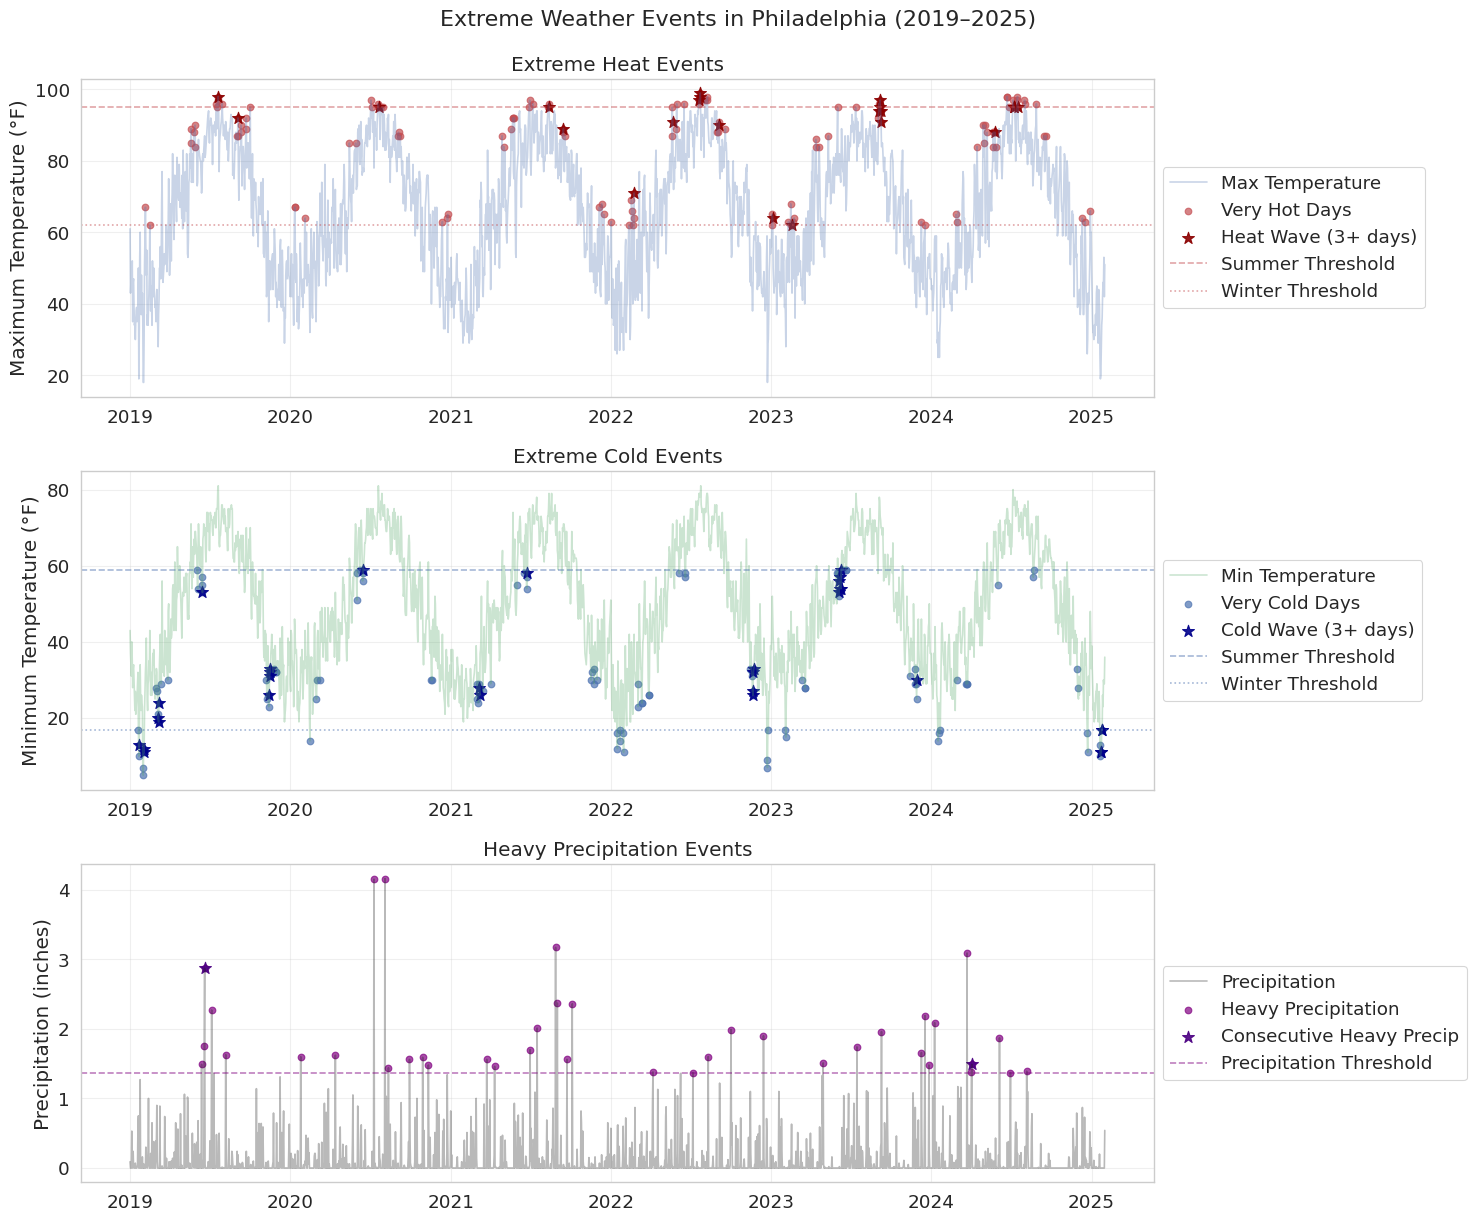

In [ ]:
# Visualize extreme weather events
plt.figure(figsize=(15, 12))

# Plot temperature extremes
ax1 = plt.subplot(3, 1, 1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['TMAX'], 'b-', alpha=0.3, label='Max Temperature')
plt.scatter(weather_with_extremes.loc[weather_with_extremes['VERY_HOT']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['VERY_HOT']==1, 'TMAX'],
            color='r', marker='o', label='Very Hot Days', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['HEATWAVE']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['HEATWAVE']==1, 'TMAX'],
            color='darkred', marker='*', s=80, label='Heat Wave (3+ days)', alpha=0.9)

plt.axhline(y=weather_thresholds['Summer']['hot_threshold'], color='r', linestyle='--', alpha=0.5, label='Summer Threshold')
plt.axhline(y=weather_thresholds['Winter']['hot_threshold'], color='r', linestyle=':', alpha=0.5, label='Winter Threshold')
plt.ylabel('Maximum Temperature (°F)')
plt.title('Extreme Heat Events')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)

# Plot cold extremes
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['TMIN'], 'g-', alpha=0.3, label='Min Temperature')
plt.scatter(weather_with_extremes.loc[weather_with_extremes['VERY_COLD']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['VERY_COLD']==1, 'TMIN'],
            color='b', marker='o', label='Very Cold Days', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['COLDWAVE']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['COLDWAVE']==1, 'TMIN'],
            color='darkblue', marker='*', s=80, label='Cold Wave (3+ days)', alpha=0.9)

plt.axhline(y=weather_thresholds['Summer']['cold_threshold'], color='b', linestyle='--', alpha=0.5, label='Summer Threshold')
plt.axhline(y=weather_thresholds['Winter']['cold_threshold'], color='b', linestyle=':', alpha=0.5, label='Winter Threshold')
plt.ylabel('Minimum Temperature (°F)')
plt.title('Extreme Cold Events')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)

# Plot precipitation extremes
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['PRCP'], 'k-', alpha=0.3, label='Precipitation')
plt.scatter(weather_with_extremes.loc[weather_with_extremes['HEAVY_PRECIP']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['HEAVY_PRECIP']==1, 'PRCP'],
            color='purple', marker='o', label='Heavy Precipitation', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['CONSEC_PRECIP']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['CONSEC_PRECIP']==1, 'PRCP'],
            color='indigo', marker='*', s=80, label='Consecutive Heavy Precip', alpha=0.9)

plt.axhline(y=weather_thresholds['precipitation'], color='purple', linestyle='--', alpha=0.5, label='Precipitation Threshold')
plt.ylabel('Precipitation (inches)')
plt.title('Heavy Precipitation Events')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)

# Adjust layout to make room for legends
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.suptitle('Extreme Weather Events in Philadelphia (2019–2025)', y=1.02, fontsize=16)
plt.show()


In [ ]:
def aggregate_weather_monthly(df):
    """
    Aggregate daily weather data to monthly level for panel data analysis.

    Parameters:
    -----------
    df : pandas.DataFrame
        Weather data with extreme event indicators

    Returns:
    --------
    pandas.DataFrame
        Monthly aggregated weather data
    """
    # Group by year and month
    agg_weather = df.groupby(['YEAR', 'MONTH']).agg({
        'VERY_HOT': 'sum',             # Count of very hot days
        'VERY_COLD': 'sum',            # Count of very cold days
        'HEAVY_PRECIP': 'sum',         # Count of heavy precipitation days
        'CONSEC_HOT': 'sum',           # Count of consecutive hot days
        'CONSEC_COLD': 'sum',          # Count of consecutive cold days
        'CONSEC_PRECIP': 'sum',        # Count of consecutive precipitation days
        'SINGLE_HOT': 'sum',           # Count of isolated hot days
        'SINGLE_COLD': 'sum',          # Count of isolated cold days
        'SINGLE_PRECIP': 'sum',        # Count of isolated precipitation days
        'HEATWAVE': 'sum',             # Count of heat wave days (3+ consecutive)
        'COLDWAVE': 'sum',             # Count of cold wave days (3+ consecutive)
        'TMAX': ['mean', 'std', 'min', 'max'],  # Temperature statistics
        'TMIN': ['mean', 'std', 'min', 'max'],
        'PRCP': ['sum', 'mean', 'max', 'count']  # Precipitation statistics
    }).reset_index()

    # Flatten multi-level columns
    agg_weather.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_weather.columns]

    # Create year-month identifier for joining
    agg_weather['YEARMONTH'] = agg_weather['YEAR'].astype(str) + '-' + agg_weather['MONTH'].astype(str).str.zfill(2)

    # Create date column for the first day of each month (for time series)
    agg_weather['DATE'] = pd.to_datetime(agg_weather['YEARMONTH'] + '-01')

    # Calculate additional variables for model
    agg_weather['DAYS_WITH_PRECIP'] = agg_weather['PRCP_count']  # Days with any precipitation
    agg_weather['PRECIP_INTENSITY'] = agg_weather['PRCP_sum'] / agg_weather['DAYS_WITH_PRECIP'].replace(0, np.nan)  # Avg intensity
    agg_weather['TEMP_RANGE'] = agg_weather['TMAX_max'] - agg_weather['TMIN_min']  # Temperature range

    # Add season column
    seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall',
              11: 'Fall', 12: 'Winter'}
    agg_weather['SEASON'] = agg_weather['MONTH'].map(seasons)

    return agg_weather

def prepare_panel_data(ridership_df, weather_df):
    """
    Merge ridership and weather data to create a balanced panel dataset.

    Parameters:
    -----------
    ridership_df : pandas.DataFrame
        Cleaned ridership data
    weather_df : pandas.DataFrame
        Monthly aggregated weather data

    Returns:
    --------
    pandas.DataFrame
        Panel dataset ready for econometric analysis
    """
    # Ensure both dataframes have the correct merge key
    if 'YEARMONTH' not in ridership_df.columns:
        print("Warning: YEARMONTH not found in ridership data. Creating it now.")
        month_map = {'January': '01', 'February': '02', 'March': '03', 'April': '04',
                    'May': '05', 'June': '06', 'July': '07', 'August': '08',
                    'September': '09', 'October': '10', 'November': '11', 'December': '12'}
        ridership_df['YEARMONTH'] = ridership_df['Year'] + '-' + ridership_df['Month'].map(month_map)

    # Merge ridership and weather data
    print(f"Ridership data shape before merge: {ridership_df.shape}")
    print(f"Weather data shape before merge: {weather_df.shape}")
    print(f"Columns in weather data: {weather_df.columns.tolist()}")
    print(f"Columns in ridership data: {ridership_df.columns.tolist()}")

    # Check overlap in merge keys
    ridership_yearmonths = set(ridership_df['YEARMONTH'].unique())
    weather_yearmonths = set(weather_df['YEARMONTH'].unique())
    print(f"Overlapping YEARMONTH values: {len(ridership_yearmonths.intersection(weather_yearmonths))}")
    print(f"Ridership-only YEARMONTH values: {len(ridership_yearmonths - weather_yearmonths)}")
    print(f"Weather-only YEARMONTH values: {len(weather_yearmonths - ridership_yearmonths)}")

    # Perform the merge
    panel_data = pd.merge(ridership_df, weather_df, on='YEARMONTH', how='left')
    print(f"Panel data shape after merge: {panel_data.shape}")

    # Check for missing values after merge
    missing_after_merge = panel_data.isnull().sum()
    missing_columns = missing_after_merge[missing_after_merge > 0]
    if len(missing_columns) > 0:
        print("\nWarning: Missing values after merging datasets:")
        print(missing_columns)

        # Handle missing values from the merge
        weather_cols = [col for col in panel_data.columns if col in weather_df.columns]

        # First, check which columns exist in the panel data
        existing_weather_cols = [col for col in weather_cols if col in panel_data.columns]

        # Then fill missing values only for these columns
        if existing_weather_cols:
            print(f"Filling missing values for {len(existing_weather_cols)} weather columns...")
            panel_data[existing_weather_cols] = panel_data[existing_weather_cols].fillna(method='ffill').fillna(method='bfill')

        # Check if any critical columns are still missing
        if 'VERY_HOT' not in panel_data.columns:
            print("Critical column 'VERY_HOT' is missing. Creating placeholder with zeros.")
            panel_data['VERY_HOT'] = 0

        if 'VERY_COLD' not in panel_data.columns:
            print("Critical column 'VERY_COLD' is missing. Creating placeholder with zeros.")
            panel_data['VERY_COLD'] = 0

        if 'HEAVY_PRECIP' not in panel_data.columns:
            print("Critical column 'HEAVY_PRECIP' is missing. Creating placeholder with zeros.")
            panel_data['HEAVY_PRECIP'] = 0

    # Fill any remaining NAs in Ridership with 0
    if 'Ridership' in panel_data.columns and panel_data['Ridership'].isna().sum() > 0:
        print(f"Filling {panel_data['Ridership'].isna().sum()} missing Ridership values with zeros.")
        panel_data['Ridership'] = panel_data['Ridership'].fillna(0)

    # Create log-transformed ridership (dependent variable)
    panel_data['LOG_RIDERSHIP'] = np.log(panel_data['Ridership'] + 1)  # Add 1 to handle zeros

    # Create entity and time identifiers for panel data analysis
    panel_data['entity'] = panel_data['ROUTE_ID'] if 'ROUTE_ID' in panel_data.columns else panel_data['Route'].astype(str)
    panel_data['time'] = panel_data['YEARMONTH']

    # Ensure MODE_CAT exists
    if 'MODE_CAT' not in panel_data.columns:
        print("MODE_CAT column missing. Creating from Mode column.")
        mode_categories = {
            'Bus': 'Bus',
            'Trackless Trolley': 'Rail',
            'Trolley': 'Rail'
        }
        panel_data['MODE_CAT'] = panel_data['Mode'].map(mode_categories)

    # Create dummy variables for categorical features
    panel_data = pd.get_dummies(panel_data, columns=['MODE_CAT', 'SEASON'], drop_first=False)

    # Ensure all required dummy variables exist
    required_dummies = ['MODE_CAT_Bus', 'MODE_CAT_Rail',
                        'SEASON_Winter', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Fall']

    for dummy in required_dummies:
        if dummy not in panel_data.columns:
            print(f"Creating missing dummy variable: {dummy}")
            panel_data[dummy] = 0

    # Create interaction terms
    panel_data['HOT_BUS'] = panel_data['VERY_HOT'] * panel_data['MODE_CAT_Bus']
    panel_data['COLD_BUS'] = panel_data['VERY_COLD'] * panel_data['MODE_CAT_Bus']
    panel_data['PRECIP_BUS'] = panel_data['HEAVY_PRECIP'] * panel_data['MODE_CAT_Bus']

    panel_data['HOT_RAIL'] = panel_data['VERY_HOT'] * panel_data['MODE_CAT_Rail']
    panel_data['COLD_RAIL'] = panel_data['VERY_COLD'] * panel_data['MODE_CAT_Rail']
    panel_data['PRECIP_RAIL'] = panel_data['HEAVY_PRECIP'] * panel_data['MODE_CAT_Rail']

    # Ensure all required columns for models exist
    required_cols = ['VERY_HOT', 'VERY_COLD', 'HEAVY_PRECIP',
                     'SINGLE_HOT', 'CONSEC_HOT', 'SINGLE_COLD', 'CONSEC_COLD',
                     'SINGLE_PRECIP', 'CONSEC_PRECIP',
                     'TMAX_mean', 'TMIN_mean', 'PRCP_sum']

    for col in required_cols:
        if col not in panel_data.columns:
            print(f"Creating missing column: {col}")
            panel_data[col] = 0

    print("Panel data preparation complete.")
    return panel_data

# Aggregate weather data to monthly level
monthly_weather = aggregate_weather_monthly(weather_with_extremes)

# Print column names in monthly_weather to debug
print("\nColumns in monthly_weather:")
print(monthly_weather.columns.tolist())

# Prepare panel dataset
panel_data = prepare_panel_data(ridership_clean, monthly_weather)

# Examine the panel structure
n_entities = panel_data['entity'].nunique()
n_time_periods = panel_data['time'].nunique()
print(f"\nPanel Structure: {n_entities} entities (routes) × {n_time_periods} time periods (months)")
print(f"Total observations: {len(panel_data)}")

# Check if the panel is balanced
entity_time_counts = panel_data.groupby('entity')['time'].count()
is_balanced = (entity_time_counts == entity_time_counts.max()).all()
print(f"Balanced panel: {is_balanced}")

# Display summary statistics
print("\nSummary Statistics:")
summary_stats = panel_data[['Ridership', 'LOG_RIDERSHIP', 'VERY_HOT', 'VERY_COLD', 'HEAVY_PRECIP',
                           'CONSEC_HOT', 'CONSEC_COLD', 'CONSEC_PRECIP',
                           'TMAX_mean', 'TMIN_mean', 'PRCP_sum']].describe()
print(summary_stats)


Columns in monthly_weather:
['YEAR', 'MONTH', 'VERY_HOT_sum', 'VERY_COLD_sum', 'HEAVY_PRECIP_sum', 'CONSEC_HOT_sum', 'CONSEC_COLD_sum', 'CONSEC_PRECIP_sum', 'SINGLE_HOT_sum', 'SINGLE_COLD_sum', 'SINGLE_PRECIP_sum', 'HEATWAVE_sum', 'COLDWAVE_sum', 'TMAX_mean', 'TMAX_std', 'TMAX_min', 'TMAX_max', 'TMIN_mean', 'TMIN_std', 'TMIN_min', 'TMIN_max', 'PRCP_sum', 'PRCP_mean', 'PRCP_max', 'PRCP_count', 'YEARMONTH', 'DATE', 'DAYS_WITH_PRECIP', 'PRECIP_INTENSITY', 'TEMP_RANGE', 'SEASON']
Ridership data shape before merge: (28013, 12)
Weather data shape before merge: (73, 31)
Columns in weather data: ['YEAR', 'MONTH', 'VERY_HOT_sum', 'VERY_COLD_sum', 'HEAVY_PRECIP_sum', 'CONSEC_HOT_sum', 'CONSEC_COLD_sum', 'CONSEC_PRECIP_sum', 'SINGLE_HOT_sum', 'SINGLE_COLD_sum', 'SINGLE_PRECIP_sum', 'HEATWAVE_sum', 'COLDWAVE_sum', 'TMAX_mean', 'TMAX_std', 'TMAX_min', 'TMAX_max', 'TMIN_mean', 'TMIN_std', 'TMIN_min', 'TMIN_max', 'PRCP_sum', 'PRCP_mean', 'PRCP_max', 'PRCP_count', 'YEARMONTH', 'DATE', 'DAYS_WITH_PREC

In [ ]:
def estimate_fixed_effects_model(data, dependent_var, explanatory_vars, entity_effects=True, time_effects=True):
    """
    Estimate a fixed effects panel data model.

    Parameters:
    -----------
    data : pandas.DataFrame
        Panel dataset with entity and time identifiers
    dependent_var : str
        Name of the dependent variable column
    explanatory_vars : list
        List of explanatory variable column names
    entity_effects : bool
        Whether to include entity fixed effects (default: True)
    time_effects : bool
        Whether to include time fixed effects (default: True)

    Returns:
    --------
    linearmodels.panel.results.PanelEffectsResults
        Fixed effects model results
    """
    # Create a copy of the data to avoid modifying the original
    panel_df = data.copy()

    # Convert time index to proper datetime format
    if not pd.api.types.is_datetime64_dtype(panel_df['time']):
        try:
            panel_df['time_date'] = pd.to_datetime(panel_df['time'] + '-01')
        except:
            try:
                panel_df['time_date'] = pd.to_datetime(panel_df['time'])
            except:
                print("Warning: Unable to convert time to datetime. Creating numeric time index.")
                unique_times = sorted(panel_df['time'].unique())
                time_map = {t: i for i, t in enumerate(unique_times)}
                panel_df['time_date'] = panel_df['time'].map(time_map)
    else:
        panel_df['time_date'] = panel_df['time']

    # Make sure entity is string type
    panel_df['entity_str'] = panel_df['entity'].astype(str)

    # Check for multicollinearity in explanatory variables
    X_check = panel_df[explanatory_vars].copy()

    # Calculate correlation matrix
    corr_matrix = X_check.corr().abs()

    # Find highly correlated pairs
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                      for i, j in zip(*np.where(upper > 0.95))]

    if high_corr_pairs:
        print("Warning: High multicollinearity detected between variables:")
        for var1, var2, corr in high_corr_pairs:
            print(f"  {var1} and {var2}: {corr:.4f}")

        # Identify and remove problematic variables
        vars_to_drop = []
        for var1, var2, _ in high_corr_pairs:
            # Choose the second variable to drop (arbitrary but consistent)
            if var2 not in vars_to_drop:
                vars_to_drop.append(var2)

        if vars_to_drop:
            print(f"Removing {len(vars_to_drop)} variables due to multicollinearity:")
            for var in vars_to_drop:
                print(f"  - {var}")
            explanatory_vars = [var for var in explanatory_vars if var not in vars_to_drop]

    # Check for variables with near-zero variance
    var_std = X_check.std()
    low_var_vars = var_std[var_std < 0.001].index.tolist()

    if low_var_vars:
        print("Warning: Variables with near-zero variance detected:")
        for var in low_var_vars:
            print(f"  - {var}: std = {var_std[var]:.6f}")

        print("Removing variables with near-zero variance:")
        explanatory_vars = [var for var in explanatory_vars if var not in low_var_vars]

    # Create formula components
    y = panel_df[dependent_var]
    X = panel_df[explanatory_vars]

    # Add constant
    X = sm.add_constant(X)

    # Set up panel data structure with properly formatted indices
    multi_index = pd.MultiIndex.from_arrays([panel_df['entity_str'], panel_df['time_date']],
                                           names=['entity', 'time'])

    # Check if multi_index has any duplicates
    if multi_index.duplicated().any():
        print("Warning: Duplicate indices found in panel data. Keeping first occurrence.")
        mask = ~multi_index.duplicated(keep='first')
        multi_index = multi_index[mask]
        y = y.iloc[mask]
        X = X.iloc[mask, :]

    y_panel = pd.Series(y.values, index=multi_index, name=dependent_var)
    X_panel = pd.DataFrame(X.values, index=multi_index, columns=X.columns)

    # Specify and estimate model - disable rank check as suggested in the error message
    model = PanelOLS(y_panel, X_panel, entity_effects=entity_effects, time_effects=time_effects)

    try:
        # First try with rank check disabled
        results = model.fit(cov_type='clustered', cluster_entity=True, check_rank=False)
        print("Model estimated successfully with rank check disabled.")
        print(results)
        return results
    except Exception as e:
        print(f"Error fitting model with rank check disabled: {e}")

        # Try alternative approach - drop one of the season dummies to avoid dummy variable trap
        print("\nTrying with alternative specification (drop one season dummy)...")
        if 'SEASON_Summer' in explanatory_vars:
            explanatory_vars.remove('SEASON_Summer')
            X = panel_df[explanatory_vars]
            X = sm.add_constant(X)
            X_panel = pd.DataFrame(X.values, index=multi_index, columns=X.columns)
            model = PanelOLS(y_panel, X_panel, entity_effects=entity_effects, time_effects=time_effects)

            try:
                results = model.fit(cov_type='clustered', cluster_entity=True, check_rank=False)
                print("Model estimated successfully after dropping a season dummy.")
                print(results)
                return results
            except Exception as e2:
                print(f"Error with alternative specification: {e2}")

        # As a last resort, estimate without fixed effects
        print("\nTrying simpler model without fixed effects...")
        try:
            model = PanelOLS(y_panel, X_panel, entity_effects=False, time_effects=False)
            results = model.fit()
            print("Simple pooled OLS model estimated successfully.")
            print(results)
            return results
        except Exception as e3:
            print(f"Still unable to fit model: {e3}")
            return None

def estimate_random_effects_model(data, dependent_var, explanatory_vars):
    """
    Estimate a random effects panel data model.

    Parameters:
    -----------
    data : pandas.DataFrame
        Panel dataset with entity and time identifiers
    dependent_var : str
        Name of the dependent variable column
    explanatory_vars : list
        List of explanatory variable column names

    Returns:
    --------
    linearmodels.panel.results.RandomEffectsResults
        Random effects model results
    """
    # Create a copy of the data to avoid modifying the original
    panel_df = data.copy()

    # Convert time index to proper datetime format
    if not pd.api.types.is_datetime64_dtype(panel_df['time']):
        try:
            panel_df['time_date'] = pd.to_datetime(panel_df['time'] + '-01')
        except:
            try:
                panel_df['time_date'] = pd.to_datetime(panel_df['time'])
            except:
                print("Warning: Unable to convert time to datetime. Creating numeric time index.")
                unique_times = sorted(panel_df['time'].unique())
                time_map = {t: i for i, t in enumerate(unique_times)}
                panel_df['time_date'] = panel_df['time'].map(time_map)
    else:
        panel_df['time_date'] = panel_df['time']

    # Make sure entity is string type
    panel_df['entity_str'] = panel_df['entity'].astype(str)

    # Check for multicollinearity (same as in fixed effects function)
    X_check = panel_df[explanatory_vars].copy()
    corr_matrix = X_check.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                      for i, j in zip(*np.where(upper > 0.95))]

    if high_corr_pairs:
        print("Warning: High multicollinearity detected between variables:")
        for var1, var2, corr in high_corr_pairs:
            print(f"  {var1} and {var2}: {corr:.4f}")

        vars_to_drop = []
        for var1, var2, _ in high_corr_pairs:
            if var2 not in vars_to_drop:
                vars_to_drop.append(var2)

        if vars_to_drop:
            print(f"Removing {len(vars_to_drop)} variables due to multicollinearity:")
            for var in vars_to_drop:
                print(f"  - {var}")
            explanatory_vars = [var for var in explanatory_vars if var not in vars_to_drop]

    # Check for variables with near-zero variance
    var_std = X_check.std()
    low_var_vars = var_std[var_std < 0.001].index.tolist()

    if low_var_vars:
        print("Warning: Variables with near-zero variance detected:")
        for var in low_var_vars:
            print(f"  - {var}: std = {var_std[var]:.6f}")

        print("Removing variables with near-zero variance:")
        explanatory_vars = [var for var in explanatory_vars if var not in low_var_vars]

    # Create formula components
    y = panel_df[dependent_var]
    X = panel_df[explanatory_vars]

    # Add constant
    X = sm.add_constant(X)

    # Set up panel data structure
    multi_index = pd.MultiIndex.from_arrays([panel_df['entity_str'], panel_df['time_date']],
                                           names=['entity', 'time'])

    # Check if multi_index has any duplicates
    if multi_index.duplicated().any():
        print("Warning: Duplicate indices found in panel data. Keeping first occurrence.")
        mask = ~multi_index.duplicated(keep='first')
        multi_index = multi_index[mask]
        y = y.iloc[mask]
        X = X.iloc[mask, :]

    y_panel = pd.Series(y.values, index=multi_index, name=dependent_var)
    X_panel = pd.DataFrame(X.values, index=multi_index, columns=X.columns)

    # Specify and estimate model
    try:
        model = RandomEffects(y_panel, X_panel)
        results = model.fit(cov_type='clustered', cluster_entity=True)
        print(results)
        return results
    except Exception as e:
        print(f"Error fitting random effects model: {e}")

        # Try alternative approach - drop one of the season dummies
        print("\nTrying random effects with alternative specification...")
        if 'SEASON_Summer' in explanatory_vars:
            explanatory_vars.remove('SEASON_Summer')
            X = panel_df[explanatory_vars]
            X = sm.add_constant(X)
            X_panel = pd.DataFrame(X.values, index=multi_index, columns=X.columns)

            try:
                model = RandomEffects(y_panel, X_panel)
                results = model.fit()
                print("Random effects model estimated successfully after specification change.")
                print(results)
                return results
            except Exception as e2:
                print(f"Error with alternative specification: {e2}")

        # As a last resort, try a pooled OLS model
        print("\nTrying simple pooled OLS model...")
        try:
            model = sm.OLS(y, X)
            results = model.fit()
            print("Simple pooled OLS model estimated successfully.")
            print(results.summary())
            # Return a placeholder object with compatible structure
            class ResultsWrapper:
                def __init__(self, ols_results):
                    self.params = ols_results.params
                    self.pvalues = ols_results.pvalues
                    self.rsquared = ols_results.rsquared
                    self.cov = pd.DataFrame(ols_results.cov_params(),
                                          index=ols_results.params.index,
                                          columns=ols_results.params.index)
            return ResultsWrapper(results)
        except Exception as e3:
            print(f"Still unable to fit model: {e3}")
            return None

# Define variable sets for different model specifications
# Simplify the base variables slightly to reduce potential multicollinearity
base_vars = ['VERY_HOT', 'VERY_COLD', 'HEAVY_PRECIP']
consec_vars = ['SINGLE_HOT', 'CONSEC_HOT', 'SINGLE_COLD', 'CONSEC_COLD',
              'SINGLE_PRECIP', 'CONSEC_PRECIP']
interaction_vars = ['VERY_HOT', 'VERY_COLD', 'HEAVY_PRECIP',
                   'HOT_BUS', 'COLD_BUS', 'PRECIP_BUS']

# Remove possibly redundant controls
controls = ['TMAX_mean', 'TMIN_mean', 'PRCP_sum']

# MODE_CAT variables might be perfectly collinear with entity fixed effects
# So we'll add these only if we're not using entity fixed effects
mode_vars = ['MODE_CAT_Bus', 'MODE_CAT_Rail']

# Debug panel data structure before running models
print("\nChecking panel data structure before modeling:")
print(f"Time column dtype: {panel_data['time'].dtype}")
print(f"Entity column dtype: {panel_data['entity'].dtype}")
print(f"Sample of time values: {panel_data['time'].head().tolist()}")
print(f"Sample of entity values: {panel_data['entity'].head().tolist()}")

# Print variable summary statistics to help diagnose multicollinearity issues
print("\nVariable summary statistics:")
for var in base_vars + controls + mode_vars:
    if var in panel_data.columns:
        var_data = panel_data[var]
        print(f"{var}: min={var_data.min()}, max={var_data.max()}, mean={var_data.mean():.4f}, std={var_data.std():.4f}")

# Run base fixed effects model (without mode variables to avoid collinearity with entity fixed effects)
print("\n==== Base Fixed Effects Model ====")
base_fe_results = estimate_fixed_effects_model(
    panel_data, 'LOG_RIDERSHIP', base_vars + controls
)

# Run model with consecutive weather effects
print("\n==== Consecutive Weather Events Model ====")
consec_fe_results = estimate_fixed_effects_model(
    panel_data, 'LOG_RIDERSHIP', consec_vars + controls
)

# Run model with mode interaction effects
print("\n==== Mode Interaction Model ====")
interaction_fe_results = estimate_fixed_effects_model(
    panel_data, 'LOG_RIDERSHIP', interaction_vars + controls
)

# Run random effects model for comparison (including mode variables since they don't conflict here)
print("\n==== Random Effects Model ====")
re_results = estimate_random_effects_model(
    panel_data, 'LOG_RIDERSHIP', base_vars + mode_vars + controls
)

# Perform Hausman test if both models were successfully estimated
if base_fe_results is not None and re_results is not None:
    hausman_stat, hausman_p = run_hausman_test(base_fe_results, re_results)
else:
    print("Skipping Hausman test due to model estimation failures.")


Checking panel data structure before modeling:
Time column dtype: object
Entity column dtype: object
Sample of time values: ['2019-01', '2019-01', '2019-01', '2019-01', '2019-01']
Sample of entity values: ['Bus_1', 'Bus_2', 'Bus_3', 'Bus_4', 'Bus_5']

Variable summary statistics:
VERY_HOT: min=0, max=0, mean=0.0000, std=0.0000
VERY_COLD: min=0, max=0, mean=0.0000, std=0.0000
HEAVY_PRECIP: min=0, max=0, mean=0.0000, std=0.0000
TMAX_mean: min=36.935483870967744, max=90.90322580645162, mean=66.2784, std=16.0545
TMIN_mean: min=23.774193548387096, max=73.70967741935483, mean=49.2248, std=15.2324
PRCP_sum: min=0.0, max=8.53, mean=3.6401, std=1.8682
MODE_CAT_Bus: min=False, max=True, mean=0.8801, std=0.3248
MODE_CAT_Rail: min=False, max=True, mean=0.0860, std=0.2804

==== Base Fixed Effects Model ====
  TMAX_mean and TMIN_mean: 0.9924
Removing 1 variables due to multicollinearity:
  - TMIN_mean
  - VERY_HOT: std = 0.000000
  - VERY_COLD: std = 0.000000
  - HEAVY_PRECIP: std = 0.000000
Removi

NameError: name 'run_hausman_test' is not defined